 # 1. Prep Work

### 1.1 Imports

In [1]:
import os
import numpy as np
import pandas as pd
import pprint

import pickle # Load refs and annotations
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration 

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO


import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np


import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import json

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw


/home/matea/Documents/VisualGrounding/DeepLearning/DeepBlasphemy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Dataset

In [2]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [26]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
from clip.simple_tokenizer import SimpleTokenizer

class RefCOCOGDataset(Dataset):
    def __init__(self, root_dir, split_type, transform=None):
        self.root_dir = root_dir
        self.split_type = split_type
        self.transform = transform
        self.annotations = self._load_annotations()

    def _load_annotations(self):
        annotations_file = os.path.join(self.root_dir + '/annotations/', 'refs(umd).p')
        with open(annotations_file, 'rb') as f:
            annotations = pickle.load(f, encoding='latin1')
        return annotations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        image_path = os.path.join(self.root_dir, 'images', f'COCO_train2014_{str(image_id).zfill(12)}.jpg')
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = annotation['sentences'][0]['raw']

        return image, caption

### 1.2 Load annotations

In [4]:
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [20]:
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
    obj = pickle.loads(fp)
pprint.pprint(obj)

TypeError: a bytes-like object is required, not '_io.BufferedReader'

### 1.3 Dataloader

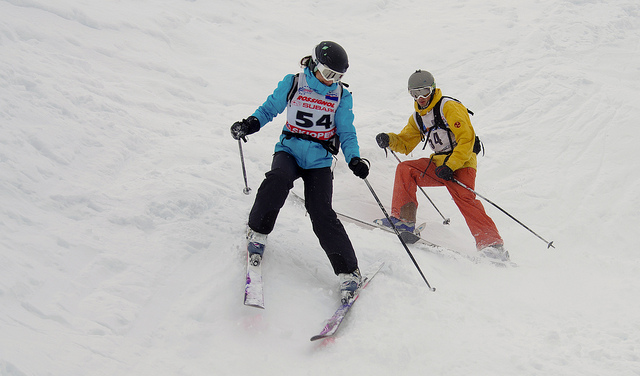

(<PIL.Image.Image image mode=RGB size=640x376 at 0x7F08CC950F10>, 'the man in yellow coat')


In [27]:
def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    #pad_width = padded_width - original_width
    #pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0) #Concatenates a sequence of tensors along a new dimension.

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    
    print(data)
    print("--------------------------")

    return images, data

def collate_fn2(batch):
    images, caption_tokens = zip(*batch)
    print(images)
    # Process images
    transform = transforms.Compose([
        transforms.Pad(0, fill=0),  # Replace padding_value with your desired padding
        transforms.Resize((224, 224)),  # ResNet-50 input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensors = torch.stack([transform(img) for img in images])

    # Tokenize the captions using the CLIP tokenizer
    #caption_lengths = [len(tokens) for tokens in caption_tokens]
    #max_caption_length = max(caption_lengths)
    captions = [item[1] for item in batch]
    #added_caption_tokens = [tokens + [0] * (max_caption_length - len(tokens)) for tokens in caption_tokens]
    caption_tensors = torch.tensor(captions)

    return {'images': image_tensors, 'captions': caption_tensors, 'caption_lengths': caption_lengths}

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
"""
dataset_train = RefCOCOg(refs, annotations, split="train")
dataset_test = RefCOCOg(refs, annotations, split="test")
plt.imshow(Image.open(dataset_train[2]["file_name"]))
plt.imshow(Image.open(dataset_test[2]["file_name"]))
dataloader_train = DataLoader(dataset_train, batch_size=1, collate_fn=collate_fn)
dataloader_test = DataLoader(dataset_test, batch_size=1, collate_fn=collate_fn)
"""

dataset_root = "./refcocog"
test = RefCOCOGDataset(root_dir=dataset_root, split_type='test')
display(test[0][0])
print(test[0])
dataloader_test = DataLoader(test, batch_size=1, collate_fn=collate_fn2)


In [31]:
for batch,(inputs,outputs) in enumerate(dataloader_test):
    print(inputs)
    print("-----------")
    print(outputs)
    break

(<PIL.Image.Image image mode=RGB size=640x376 at 0x7F08CD66E9D0>,)


TypeError: can only concatenate str (not "list") to str

### 1.5 Utils

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def load_image_plt(path):
    """ Load image with matplotlib"""
    return plt.imread(path)

def load_image_pil(path):
    """ Load image with PIL"""
    return Image.open(path)

def get_distance_box_iou_accuracy(box_pred, box_true, iou_threshold=0.5):
    """
    Given the target boxes and the prediction return the
    accuracy of the prediction. The accuracy is computed as
    the percentage of boxes that have an IoU > iou_threshold
    with the target box.

    Args:
    @params box_pred: tensor of shape (batch_size, n_boxes, 4)
    @params box_true: tensor of shape (batch_size, n_boxes, 4)
    @params iou_threshold: float

    Returns:
    @params accuracy: float

    """

    iou = torchvision.ops.box_iou(box_pred, box_true).diagonal()
    giou = torchvision.ops.generalized_box_iou(box_pred, box_true).diagonal()

    return (iou > iou_threshold).float().mean(), iou.mean(), giou.mean()

# 2. Baseline

### 2.1 Gigiate Random

In [ ]:
model, preprocess = clip.load("RN50")
model = model.cuda().eval()

In [8]:
def encode_data(images_fp: list[str], texts: list[str]):
  # preprocess the images to transform from filenames to images to tensors
  images = [preprocess(Image.open(image)) for image in images_fp]

  # preprocess the texts to transform from text to tensors
  images = torch.tensor(np.stack(images)).cuda()
  text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

  # encode the inputs
  with torch.no_grad():
    images_z = model.encode_image(images).float()
    texts_z = model.encode_text(text_tokens).float()
  
  return images_z, texts_z

def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()
"""
def get_data():
  a = 0
  images = []
  texts = []

  for d in dataloader:
    texts.append(d[1]["caption"][0])
    if a == 4:
        break
    a += 1
  a = 0
  for d in dataset:
    images.append(d['file_name'])
    if a == 4:
        break
    a += 1
    
  return images, texts

images_fp, texts = get_data()
"""

'\ndef get_data():\n  a = 0\n  images = []\n  texts = []\n\n  for d in dataloader:\n    texts.append(d[1]["caption"][0])\n    if a == 4:\n        break\n    a += 1\n  a = 0\n  for d in dataset:\n    images.append(d[\'file_name\'])\n    if a == 4:\n        break\n    a += 1\n    \n  return images, texts\n\nimages_fp, texts = get_data()\n'

In [ ]:
images_z, texts_z = encode_data(images_fp, texts)
similarity = cosine_similarity(images_z, texts_z)
print(similarity)

NameError: name 'images_fp' is not defined

In [9]:
# Constants and models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# YOLO
model_yolo = YOLO("yolov8x.pt")

# CLIP
clip_model, clip_preprocess = clip.load("RN50", device=device)

### 2.2 FineTuning

#### 2.2.1 Creating train, validation and test set

In [10]:
def SplitData(batch_size=64, transform=None, test_batch_size=64):
    if not transform:
        # convert the PIL images to Tensors
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    # load data
    full_training_data = RefCOCOGDataset(root_dir=dataset_root, split_type='train')
    test_data = RefCOCOGDataset(root_dir=dataset_root, split_type='test')
    # create train and validation splits
    num_samples = len(full_training_data)
    training_samples = int(num_samples * 0.5 + 1)
    validation_samples = num_samples - training_samples

    training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

    # initialize dataloaders
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

#### 2.2.2 Test Step Zero-Shot Clip

In [18]:
def test_step_zero_shot_clip(net, data_loader, texts_z, device='cuda'):
  samples = 0.0
  cumulative_accuracy = 0.0

  # set the network to evaluation mode
  net.eval()

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    # iterate over the test set
    for batch, (inputs,targets) in enumerate(data_loader):

      print(data.keys())
      #print(targets)
      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # forward pass
      # these two lines are different from the "traditional" ones
      images_z = model.encode_image(inputs).float()
      outputs = (100 * images_z @ texts_z.T).softmax(dim=-1)

      # fetch prediction and loss value
      samples += inputs.shape[0]
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_accuracy / samples * 100

In [20]:
def test_step_zero_shot_clip2(net, data_loader, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0


  # set the network to evaluation mode
  net.eval()

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    # iterate over the test set
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      outputs = net(inputs)

      # loss computation
      loss = cost_function(outputs, targets)

      # fetch prediction and loss value
      samples += inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

In [21]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

#### 2.2.3 Tokenize 

In [ ]:
for d in dataset:
    print(d['caption'])
    break

Two woman one in black eatting and the other has a white shirt at the desk


In [12]:
def tokenize_batches(dataset, batch_size):
    # Extract descriptions from the dataset
    descriptions = [data['target'] for data in dataset]
    
    # Initialize lists to store tokenized textual features
    all_texts_z = []

    # Tokenize and encode in batches
    for batch_start in range(0, len(descriptions), batch_size):
        batch_descriptions = descriptions[batch_start:batch_start + batch_size]

        # Tokenize batch and move to GPU
        text_tokens = clip.tokenize(batch_descriptions).cuda()

        # Encode batch and normalize
        with torch.no_grad():
            texts_z = model.encode_text(text_tokens).float()
            texts_z /= texts_z.norm(dim=-1, keepdim=True)

        all_texts_z.append(texts_z)

    # Concatenate and return all batches
    return torch.cat(all_texts_z, dim=0)

In [ ]:
model, preprocess = clip.load("RN50")
model = model.cuda().eval()

In [17]:
#dataset_name = "cifar10"

batch_size_token = 64

#_, _, test_loader = SplitData(transform=preprocess)
texts_z = tokenize_batches(test,batch_size_token)


AttributeError: 'list' object has no attribute 'find'

In [ ]:
print(test_loader[0])

TypeError: 'DataLoader' object is not subscriptable

In [24]:
cost_function = get_cost_function()

test_accuracy = test_step_zero_shot_clip2(model, dataloader_test, cost_function)

print("Test accuracy {:.2f}".format(test_accuracy))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>